In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [18]:
import glob
directory = "/data/MCMC/"
files = sorted( glob.glob(directory + "par*.bin"), 
                key=lambda x:int(x.split("/")[-1][3:].split('_')[0]))
bins = []
for line in open("/data/MCMC/metadata.txt","r"):
    line = line.split()
    if line[0] == "bins": 
        bins = map(float, line[1:])

In [20]:
import struct

data = {}
for fname in files:
    with open(fname, "rb") as f: 
        size = int(struct.unpack('<i', f.read(4))[0])
        data[fname] = np.fromfile(f,np.float32)
data = pd.DataFrame(data)[files]
dataP = data.iloc[:,:len(data.columns)/2]
dataP.columns = bins[:-1]
dataD = data.iloc[:,len(data.columns)/2:]
dataD.columns = bins[:-1]

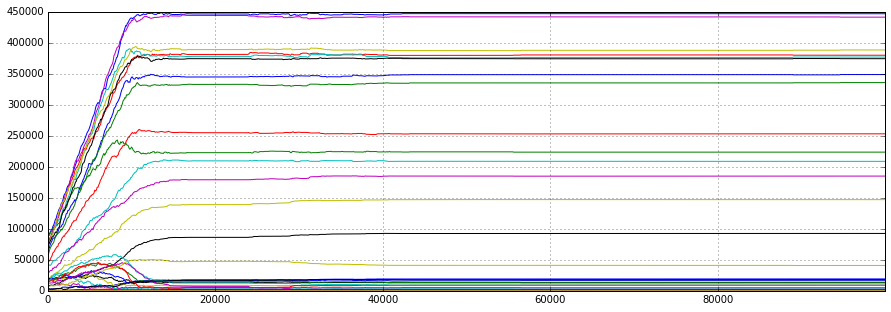

In [24]:
figsize(15,5)
data.iloc[:100000:100].plot(legend=False)
yklin

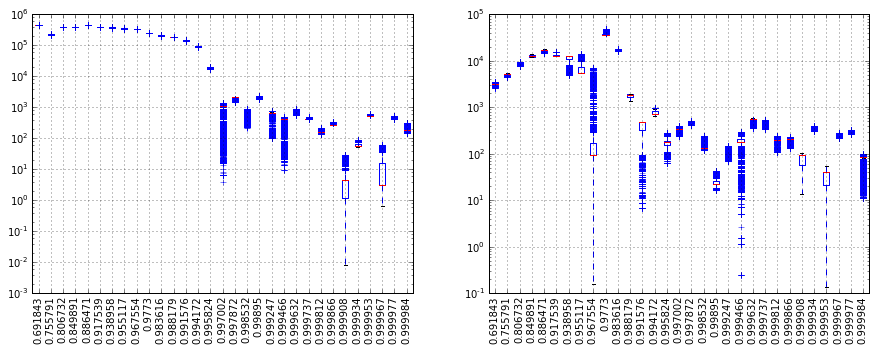

In [25]:
figsize(15, 5)
subplot(121)
dataP.iloc[20000:].boxplot();
xticks(rotation='vertical')
yscale("log")

subplot(122)
dataD.iloc[20000:].boxplot();
xticks(rotation='vertical')
yscale("log")

In [29]:
import seaborn as s
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "jet"})
figsize(12,10)
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['savefig.facecolor'] = (1,1,1,1)

def plot_matrix(frame, **args):
        x,y = np.meshgrid(np.array(frame.index,   dtype=float),
                      np.array(frame.columns, dtype=float))
    z = frame.T.values.astype(float)
    ret = gca().pcolor(y,x,z, **args)
    (lambda x: xlim(x[0],x[-1]))(frame.columns)
    (lambda x: ylim(x[0],x[-1]))(frame.index  ) 
    return ret

In [31]:
frame = pd.DataFrame.from_csv("../mcmc/datasets/R_resolution.csv")
frame = frame.divide(frame.sum(axis=1),axis=0)
rgdtMeasured  = np.array(frame.columns.astype(float))
rgdtTheoretic = np.array(frame.index.astype(float))
rgdtF = frame.values[:-1,:-1]

frame = pd.DataFrame.from_csv("../mcmc/datasets/B_resolution.csv")
frame = frame.divide(frame.sum(axis=1),axis=0)
betaMeasured  = np.array(frame.columns.astype(float))
betaTheoretic = np.array(frame.index.astype(float))
betaF = frame.values[:-1,:-1]

In [36]:
!cp ../mcmc_py/pd_model.py .
from pd_model import *

In [37]:
model = PDModel(
    betaBinsTheoretic=betaTheoretic,
    betaBinsMeasured=betaMeasured ,
    rgdtBinsTheoretic=rgdtTheoretic, 
    rgdtBinsMeasured=rgdtMeasured 
)
model.set_rigidity_resolution(rgdtF)
model.set_beta_resolution(betaF)

In [93]:
fluxP = dataP.iloc[100000]
fluxD = dataD.iloc[100000]
r = model(fluxP, fluxD)
frame = pd.DataFrame(r, columns=rgdtMeasured[:-1], index=betaMeasured[:-1])

obs = pd.DataFrame.from_csv("../mcmc/datasets/observed_data.txt", sep=' ',header=-1, index_col=False)
obs = obs.iloc[:-1,:-1]
obs.columns=rgdtMeasured[:-1]
obs.index=betaMeasured[:-1]

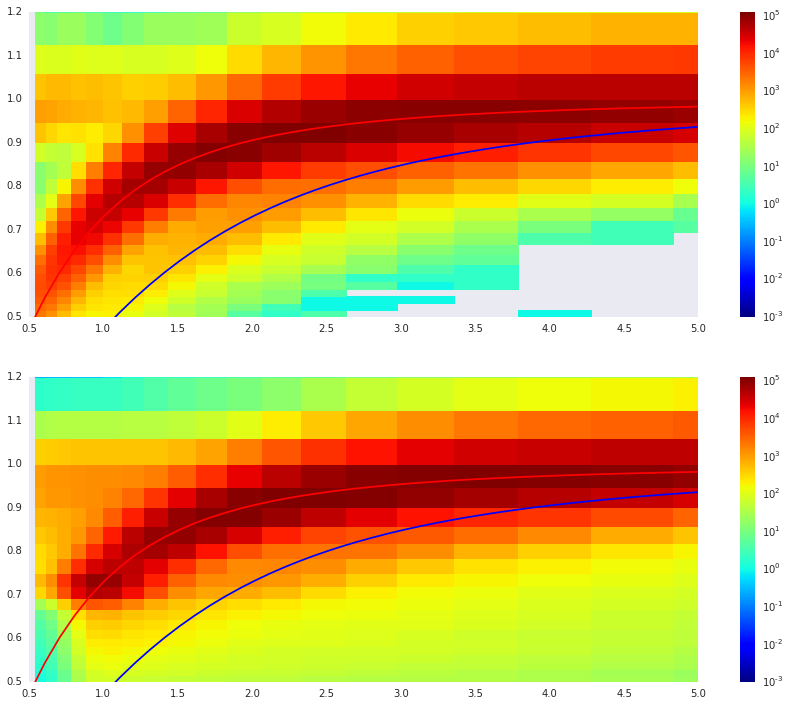

In [94]:
figsize(15,12)
subplot(211)
ax = plot_matrix(obs,norm=LogNorm(vmin=0.001,vmax=obs.values.max()))
colorbar(ax)
xlim(0.5,5.0)
ylim(0.5,1.2)

x = np.linspace(0,10,100)
plot(x, beta_from_R(x,mp),'r')
plot(x, beta_from_R(x,md),'b')


subplot(212)
ax = plot_matrix(frame,norm=LogNorm(vmin=0.001,vmax=obs.values.max()))
colorbar(ax)
xlim(0.5,5.0)
ylim(0.5,1.2)

x = np.linspace(0,10,100)
plot(x, beta_from_R(x,mp),'r')
plot(x, beta_from_R(x,md),'b')



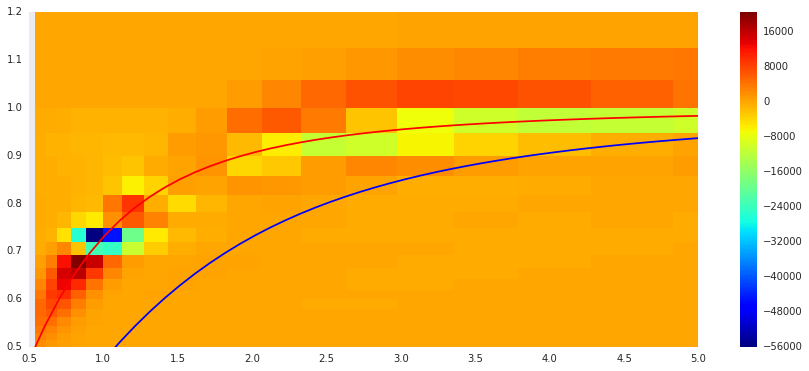

In [95]:
figsize(15,6)
ax = plot_matrix(obs-frame)#, norm=Normalize(vmin=-1, vmax=1))
xlim(0.5,5.0)
ylim(0.5,1.2)
colorbar(ax)
x = np.linspace(0,10,100)
plot(x, beta_from_R(x,mp),'r')
plot(x, beta_from_R(x,md),'b')

In [67]:
ax